# CS 497/597: Tensorflow With Mobilenet V2

## Purpose of the assignment:

To familiarize ourselves with Tensorflow and MobileNet V2 by training, tuning, and explaining how MobileNet V2 works by training it on both CIFAR100 and a dataset of our choosing. 

### Step 1: Data Preprocessing

In [87]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import logging

import keras_tuner as kt

In [18]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [19]:
# Import the training and test data for CIFAR100 and load 
# the fine grained class labels so we can use all 100 classes

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode='fine')

In [4]:
# Print the shape of the training and testing images and labels
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


Note: CIFAR100 contains 60,000 images total with 100 classes. Each image is size 32 x 32 with RGB values for a total of 32 x 32 x 3 size per image. This means that each image is somewhat small in size, with only 1024 pixels and 3072 values total including RGB pixel values. The dataset loaded here is split into 50K training images and 10K test images (80% training and 20% testing).

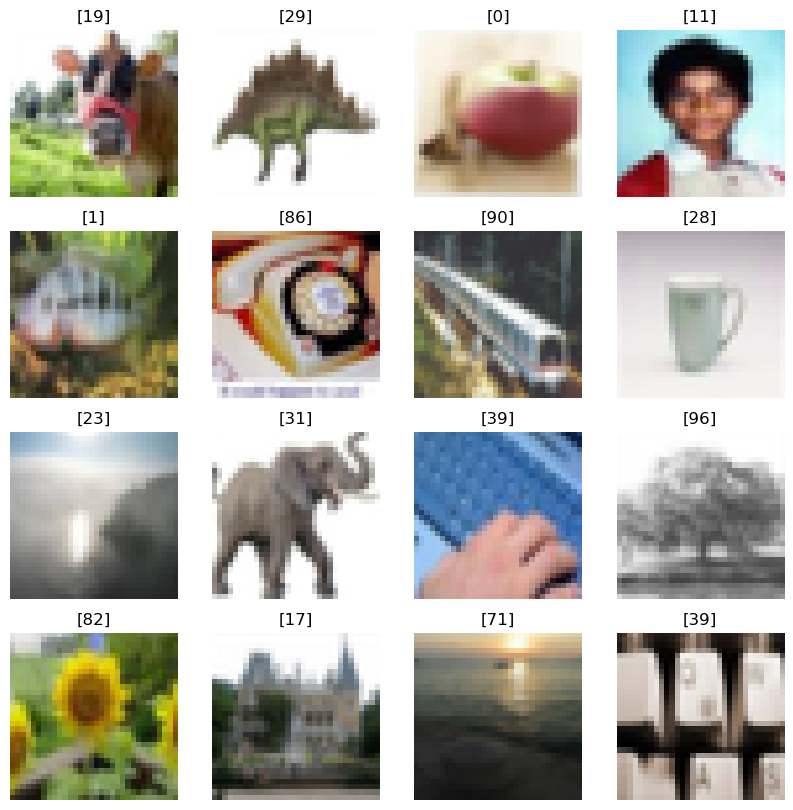

In [5]:
# Show 16 example images from the CIFAR100 dataset
plt.figure(figsize=(10,10))

for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.axis("off")

Looking at the first 16 images in the training dataset, it is clear that 1024 pixels doesn't leave room for a lot of detail. Most of the images are blurry with little space for even large patterns. The image at the bottom right appears to be a keyboard, but the image is so small that it is impossible to read what keys are displayed in the image. The image in the bottom left is an image with 3 sunflowers, but it is so pixelated that it is difficult to see how many flower petals each sunflower has. This lack of detail could either help a CNN focus on key features of an image or hurt a CNN by blurring important features that can help it distinguish between classes. We cannot know for sure whether this improves or harms MobileNet's performance until it is tested. 

In [6]:
# Split the test dataset into testing and validation datasets for tuning and testing MobileNetVs2

division_point = int(x_test.shape[0]/2)
x_validation, y_validation = x_test[0:division_point], y_test[0:division_point]
X_test, Y_test = x_test[division_point:x_test.shape[0]], y_test[division_point:x_test.shape[0]]

In [61]:
# Run data augmentation to randomize incoming images and prevent overfitting with ImageNet
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2),
])

### Step 2: Model Construction

In [99]:
# Construct a model built on top of MobileNetV2 with an
# input layer that takes in an image of the dimensions specified
# in x_data, sends said image into mobilenet, and then takes the
# output from mobilenet into a simple classifiation head that 
# predicts what label said image is from a range of labels.
# This function will return the constructed (but not compiled)
# mobilenet V2 model
def build_mobilenet_model(x_data, y_data):

    # Prepare base MobileNet V2 model
    base_mobilenet = tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, include_top=False, weights="imagenet")

    # Get the prediction size of the data
    prediction_size = len(set(y_data.flatten()))

    # Create a global average layer for pooling the output from MobileNetV2
    global_average_layer = keras.layers.GlobalAveragePooling2D()
    
    # Create an intermediate dense layer between the average pooling layer and final prediction layer
    hidden_output_layer = keras.layers.Dense(500, activation='sigmoid')
    

    # Create a prediction layer for each class in the CIFAR100 dataset
    prediction_layer = keras.layers.Dense(prediction_size, activation='sigmoid')
    
    # Create an input layer for the image itself
    input = tf.keras.Input(shape=x_data[0].shape)
    # Apply data augmentation pipeline
    x = data_augmentation(input)
    # Run the augmented image through MobileNet and train it
    x = base_mobilenet(x, training=True)
    # Average the output of all RELU functions for the fully connected layer
    x = global_average_layer(x)
    # apply dropout to prevent overfitting
    x = keras.layers.Dropout(0.2)(x)
    # apply a hidden dense layer between the global pooling layer and prediction layer
    x = hidden_output_layer(x)
    # Get the final prediction of the model with a single fully connected layer
    output = prediction_layer(x)
    # Construct the model and pipeline
    model = keras.Model(input, output)

    # return constructed model
    return model

In [78]:
# Download and construct a base MobileNet V2 model on top of ImageNet weights
base_mobilenet = tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, include_top=False, weights="imagenet")

/tmp/ipykernel_3625/4197228902.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobilenet = tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, include_top=False, weights="imagenet")


In [80]:
# Create a small batch from the training dataset for simple testing
training_dataset = tf.data.Dataset.from_tensor_slices((x_train, keras.utils.to_categorical(y_train))).batch(batch_size=64)
image_batch, label_batch = next(iter(training_dataset))
print(image_batch.shape)
feature_batch = base_mobilenet(image_batch)
print(feature_batch.shape)

(64, 32, 32, 3)
(64, 1, 1, 1280)


In [81]:
# Create the validation and testing datasets

validation_dataset = tf.data.Dataset.from_tensor_slices((x_validation, keras.utils.to_categorical(y_validation))).batch(batch_size=64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, keras.utils.to_categorical(Y_test))).batch(batch_size=64)

In [82]:
# Set up the prediction head for MobileNetV2 for CIFAR100

# Create a global pooling layer for the output RELU functions
global_average_layer = keras.layers.GlobalAveragePooling2D()
sample_average = global_average_layer(feature_batch)

# Create an intermediate dense layer between the average pooling layer and final prediction layer
hidden_output_layer = keras.layers.Dense(500, activation='sigmoid')
hidden_output_batch = hidden_output_layer(sample_average)

# Create a prediction layer for each class in the CIFAR100 dataset
prediction_layer = keras.layers.Dense(100, activation='sigmoid')
prediction_batch = prediction_layer(hidden_output_batch)
print(prediction_batch.shape)

(64, 100)


In [100]:
model = build_mobilenet_model(x_train, y_train)
print(model.summary())

/tmp/ipykernel_3625/953266383.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobilenet = tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, include_top=False, weights="imagenet")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       640,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        50,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,948,584 (11.25 MB)

 Trainable params: 2,914,472 (11.12 MB)

 Non-trainable params: 34,112 (133.25 KB)

None


In [84]:
# Create a model for hyperparameter tuning based on current model architecture
tuning_model = keras.models.clone_model(model)

In [68]:
#3 Show the fully constructed model's parameter count and memory footprint including the base MobileNet V2 model
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 500)            │       640,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        50,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,948,584 (11.25 MB)

 Trainable params: 2,914,472 (11.12 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Step 3: Train Extended MobileNetV2 Model on CIFAR100 Dataset

In [70]:
# Set the learning rate, optimizer, loss function, and evaluation metrics for the model
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy(name="accuracy"),
                       keras.metrics.Recall(name="recall"),
                       keras.metrics.Precision(name="precision"),
                       keras.metrics.F1Score(name="f1 score")])

In [71]:
# Train MobileNet for 10 epochs total
total_epochs = 15
history = model.fit(training_dataset, epochs=total_epochs, validation_data=validation_dataset)

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 43ms/step - accuracy: 0.0514 - loss: 4.4329 - val_accuracy: 0.0604 - val_loss: 4.2684
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.1890 - loss: 3.4424 - val_accuracy: 0.1660 - val_loss: 3.6658
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.2621 - loss: 2.9791 - val_accuracy: 0.2846 - val_loss: 3.0413
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.3108 - loss: 2.7232 - val_accuracy: 0.3242 - val_loss: 2.6884
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.3513 - loss: 2.5336 - val_accuracy: 0.3464 - val_loss: 2.5666
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.3778 - loss: 2.3947 - val_accuracy: 0.3862 - val_loss: 2.3492
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4019 - loss: 2.2759 - val_accuracy: 0.4256 - val_loss: 2.2125
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4259 - loss: 2.1765 - 

In [72]:
# Save the trained model weights for the extended MobileNetV2 model 
model.save_weights(filepath="checkpoints/train/MobileNetV2_CIFAR100.weights.h5", overwrite=True)

In [85]:
def graph_accuracy_loss(history):
    # Plot the validation and training accuracy and loss of MobileNetV2 across all training epochs
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the training and validation accuracies for CIFAR100
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.xticks(range(0, total_epochs, 1))

    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy For MobileNet V2 on CIFAR100 Dataset')

    #Plot the training and validation losses for CIFAR100
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.xticks(range(0, total_epochs, 1))

    # Show both the training and validation accuracies
    plt.show()

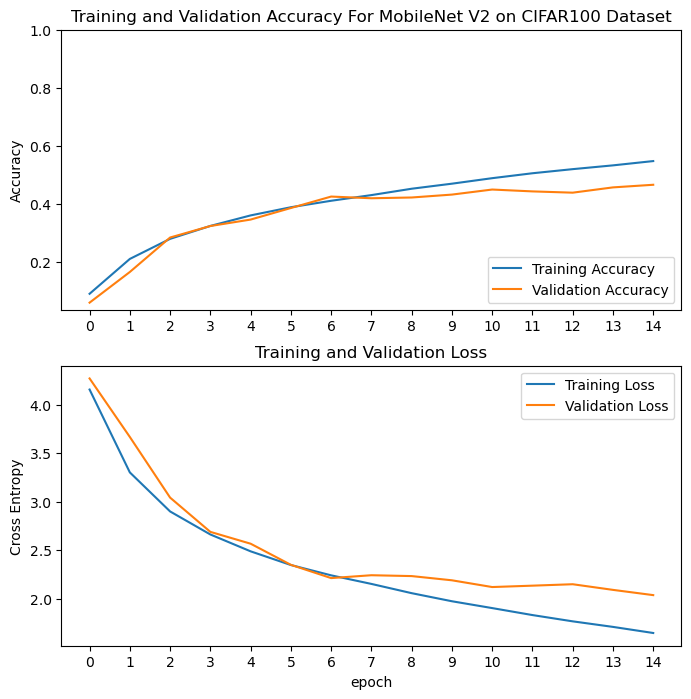

In [86]:
# Plot the validation and training accuracy and loss of MobileNetV2 across all training epochs
graph_accuracy_loss(history=history)

### Step 4: Hyperparameter Tuning for MobileNet V2

In [94]:
# Use copied model from trained model for hyperparameter tuning
def model_builder(hp):
    hp_learning_rate = hp.Choice('learning_rate',values=[1e-3,1e-4,1e-5,1e-6])
    tuning_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=[keras.metrics.CategoricalAccuracy(name="accuracy"),
                        keras.metrics.Recall(name="recall"),
                        keras.metrics.Precision(name="precision"),
                        keras.metrics.F1Score(name="f1_score")])
    
    return tuning_model

In [95]:
tuner = kt.Hyperband(model_builder,
                     objective="val_accuracy",
                     max_epochs=10,
                     factor=3,
                     project_name="MobileNetV2_CIFAR100")

stop_early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

Reloading Tuner from ./MobileNetV2_CIFAR100/tuner0.json


In [96]:
tuner.search(x_train, keras.utils.to_categorical(y_train), epochs=50, validation_data=(x_validation, keras.utils.to_categorical(y_validation)))

Trial 4 Complete [00h 02m 26s]
val_accuracy: 0.017999999225139618

Best val_accuracy So Far: 0.017999999225139618
Total elapsed time: 00h 06m 36s
